# Importando bibliotecas

In [1]:
import logging
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
import time
from datetime import datetime
import sys
import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel


# Validação dos dados simulados

In [11]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        # 1: 'Abrupt Increase of BSW',
          2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' , 'PPO', 'A2C', 'RNA'
    type_instance= 'simulated' # real, simulated
    path_dataset = '..\\..\\..\\dataset'
    instances = LoadInstances(path_dataset)
            
    logging.info(f'Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
    logging.info(f'Fim carregamento do dataset')
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')
        
    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino

    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

    env_train = Env3WGym(dataset_train_scaled, n_envs = 5)
    env_test = Env3WGym(dataset_test_scaled, n_envs = 1)

    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    path_tensorboard = f'..\\models\\{event_name}-{type_instance}'   
    if not os.path.exists(path_tensorboard):
                os.makedirs(path_tensorboard)

    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS = 100000)

    list_timesteps = [100000] # 1000, 10000, 100000, 150000, 300000
    
    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}-{type_instance}'               
            path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)   
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')
          
            logging.info(f'Iniciando a execução do algoritmo {model_type}-{type_instance} para o evento {event_name} com timesteps {agente.TIMESTEPS}')
                        
            if model_type == 'DQN':                
                
                for i in list_timesteps:
                    agente.TIMESTEPS = i
                    try:
                        logging.info(f'Iniciando treinamento do algoritmo DQN {agente.TIMESTEPS} timesteps')    
                        start_time = time.time()                
                        model_agent, replaydir = agente.env3W_dqn(path_save=path_model)  
                        print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                        logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                        logging.info(f'Fim treinamento do algoritmo DQN')

                        try:
                            logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                            accuracy = agente.env3W_dqn_eval(model = model_agent, path_save=path_model)
                            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                            logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                        except Exception as e:
                            logging.error(f'Erro ao avaliar o modelo DQN: {e}')

                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo DQN: {e}')
                
            elif model_type == 'PPO':      
                
                for i in list_timesteps:
                    agente.TIMESTEPS = i
                    logging.info(f'Iniciando treinamento do algoritmo PPO {agente.TIMESTEPS} timesteps') 
                    start_time = time.time()
                    #agente = Agent(path_model)
                    model_agent = agente.env3W_ppo(path_save=path_model)  
                    print(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                    logging.info(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                    logging.info(f'Fim treinamento do algoritmo PPO')
                                
                    logging.info(f'Iniciando avaliação do algoritmo PPO conjunto de teste')
                    accuracy = agente.env3W_ppo_eval(model = model_agent, path_save=path_model)
                    print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando PPO')
                    logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando PPO')
                    logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')
               
            elif model_type == 'A2C': 

                for i in list_timesteps:
                    agente.TIMESTEPS = i                
                    try:     
                        logging.info(f'Iniciando treinamento do algoritmo A2C') 
                        start_time = time.time()
                        #agente = Agent(path_model)
                        model_agent = agente.env3W_a2c(path_save=path_model)  
                        print(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                        logging.info(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                        logging.info(f'Fim treinamento do algoritmo A2C')
                    
                        try:
                            logging.info(f'Iniciando avaliação do algoritmo A2C conjunto de teste')
                            accuracy = agente.env3W_a2c_eval(model = model_agent, path_save=path_model)
                            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando A2C')
                            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando A2C')
                            logging.info(f'Fim avaliação  do algoritmo A2C conjunto de teste')
                        except Exception as e:
                            logging.error(f'Erro ao avaliar o modelo A2C: {e}')

                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo A2C: {e}')
            
            elif model_type == 'RNA':
                try:
                    logging.info(f'Iniciando treinamento do modelo RNA') 
                    dataset_train_scaled[:, -1] = np.where(dataset_train_scaled[:, -1] == 101, 1, dataset_train_scaled[:, -1])
                    dataset_test_scaled[:, -1] = np.where(dataset_test_scaled[:, -1] == 101, 1, dataset_test_scaled[:, -1])
                    supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                    start_time = time.time()
                    model_agent = supervised.keras_train()  
                    print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                    logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                    logging.info(f'Fim treinamento do modelo RNA')

                    try:
                        logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                        accuracy = supervised.keras_evaluate(model_agent)
                        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                        logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')
                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo RNA: {e}')
                except Exception as e:
                    logging.error(f'Erro ao treinar o modelo RNA: {e}')

            logging.info(f'Iniciando a validação do modelo {model_type}') 
            validation = ValidationModel(model_type, event_name)
            validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
            # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
            for handler in logging.root.handlers[:]:
                handler.close()
                logging.root.removeHandler(handler)
   

Número de amostras da classe 0: 57600
Número de amostras da classe 2: 345584
Número de amostras da classe 102: 57600


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TensorBoard started at http://localhost:6006/
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Spurious Closure of DHSV-simulated\tensorboard_logs'
Tempo de Treinamento DQN: 98.45s
Acurácia de 99.12% no conjunto de dados de teste usando DQN
Acurácia final: 99.536% no conjunto de dados de validação


# Validação com dados reais

In [ ]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' 
    type_instance= 'real' # real, simulated
    path_dataset = '..\\..\\..\\dataset'
    instances = LoadInstances(path_dataset)
    model_type = models[0]
            
    logging.info(f'Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
    logging.info(f'Fim carregamento do dataset')    
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')        
    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino
    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)
   
    env_train = Env3WGym(dataset_train_scaled, n_envs = 5)
    env_test = Env3WGym(dataset_test_scaled, n_envs = 1)

    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    env_test_cl = Env3WGym(dataset_test_scaled, n_envs = 5)
    envs_cl = env_test_cl.envs_random()

    directory = f'..\\..\\logs\\{event_name}-{type_instance}-CL'
    path_dataset = '..\\..\\..\\dataset'   
    path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

    if not os.path.exists(directory):
        os.makedirs(directory)

    if not os.path.exists(path_model):
        os.makedirs(path_model)    

    path_tensorboard = f'..\\models\\{event_name}-{type_instance}-CL'   
    if not os.path.exists(path_tensorboard):
        os.makedirs(path_tensorboard)

    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS = 100000)            

            
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
    # Configuração do Logging
    logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, 
                        format='[%(levelname)s]\t%(asctime)s - %(message)s', 
                        datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')
   

    if model_type == 'DQN':
        
        logging.info(f'Iniciando o teste do algoritmo DQN (Continual Learning)')    
        #start_time = time.time()
        #model_agent = agente.env3W_dqn(path_save=path_model)  
        #print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f'Fim treinamento do algoritmo DQN')
        

        # Carrega o modelo treinado em simulação com 100k passos
        path_model_zip = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "_DQN.zip")
        
        # Avalia o modelo treinado em simulação com 100k passos no ambiente real
        model_agent = DQN.load(path_model_zip) 
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
        accuracy = agente.env3W_dqn_eval(model = model_agent, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')

        # Carrega o replay buffer do modelo treinado em simulação com 100k passos 
        replay_buffer_path = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "replay_buffer", "dqn_save_replay_buffer.pkl")
        
        # Retreina o modelo com o replay buffer do modelo treinado em simulação com 10k passos do modelo real
        model_agent_cl = agente.env3W_dqn_cl(model_agent = model_agent, path_save=path_model, envs = envs_cl, 
                                             replaydir = replay_buffer_path, total_timesteps = 50000)
        
        # Avalia o modelo retreinado com 10k passos do ambiente real
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste (Continual Learning)')
        accuracy = agente.env3W_dqn_eval(model = model_agent_cl, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste (Continual Learning)')   

    # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
    for handler in logging.root.handlers[:]:
        handler.close()
        logging.root.removeHandler(handler)
    

# Geração de gráficos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados extraídos das imagens
modelos = ['A2C', 'DQN', 'PPO']
passos = np.array([1, 10, 100, 150, 300])  # Representando 10k passos de intervalo

# Acurácia dos modelos com 10k em 10k passos, convertendo para porcentagem
valores_DQN = np.array([0.29166, 0.72747, 0.92344, 0.93021, 0.94559]) * 100
valores_PPO = np.array([0.50828, 0.80014, 0.86720, 0.90412, 0.89472]) * 100
valores_A2C = np.array([0.49757, 0.49757, 0.77329, 0.77952, 0.80008]) * 100

plt.figure(figsize=(4, 4))

# Plots para cada modelo
plt.plot(passos, valores_DQN, marker='o', color='#F79646', label='DQN')
plt.plot(passos, valores_PPO, marker='s', color='#C0504D', label='PPO')
plt.plot(passos, valores_A2C, marker='^', color='#9C00A7', label='A2C')  # Alterado para melhor visibilidade

# Personalizações
plt.xlabel('Passos (milhares)')
plt.ylabel('Acurácia (%)')
plt.xticks(passos, rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('..\\..\\img\\grafico_acuracia3.png', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados extraídos das imagens
modelos = ['A2C', 'DQN', 'PPO']

# Acurácia dos modelos com 10k em 10k passos
valores_DQN = [0.7911,
  0.87225,
  0.9013,
  0.87937,
  0.92252,
  0.91683,
  0.93927,
  0.9493,
  0.88589,
  0.94434,
  0.50395,
  0.93821,
  0.90226,
  0.81794,
  0.88619,
  0.84911,
  0.62753,
  0.71075,
  0.9028,
  0.95265,
  0.91927,
  0.88583,
  0.9227,
  0.92264,
  0.93083,
  0.94742,
  0.95284,
  0.94246,
  0.94742,
  0.94083]
#[80.76, 88.11, 94, 91.53, 86.73, 94.24, 92.25, 94.84, 82.84, 90.07]
valores_PPO = [0.74739,
  0.79719,
  0.8091,
  0.40587,
  0.81019,
  0.76256,
  0.40587,
  0.75161,
  0.80943,
  0.80385,
  0.81926,
  0.79612,
  0.8465,
  0.78194,
  0.81106,
  0.39265,
  0.39265,
  0.39265,
  0.3973,
  0.433,
  0.76758,
  0.40685,
  0.40168,
  0.40472,
  0.81062,
  0.80889,
  0.27819,
  0.80542,
  0.78754,
  0.80283]
#[80.51, 67.62, 81,  40.11, 40.49, 80.36, 79.21, 79.74, 77.66, 40.48]
valores_A2C = accuracies = [
    0.50870, 0.50730, 0.50440, 0.50704, 0.50900,
    0.50388, 0.51218, 0.50802, 0.51214, 0.55713,
    0.50500, 0.51191, 0.50919, 0.51024, 0.50741,
    0.50582, 0.50376, 0.50029, 0.49884, 0.49658,
    0.49522, 0.49387, 0.49241, 0.49095, 0.48950,
    0.48804, 0.48659, 0.48513, 0.48368, 0.48223
]

# multiplicando por 100 para obter a porcentagem
valores_DQN = [x * 100 for x in valores_DQN]
valores_PPO = [x * 100 for x in valores_PPO]
valores_A2C = [x * 100 for x in valores_A2C]


#[50.25, 49.87, 50.47, 50.43, 51.19, 50.82, 50.42, 50.75, 51.26, 50.99]

passos = np.arange(10, 301, 10)  # Representando 10k passos de intervalo, de 10k até 100k

plt.figure(figsize=(8, 4))

# Plots para cada modelo
plt.plot(passos, valores_DQN, marker='o', color='#F79646', label='DQN')
plt.plot(passos, valores_PPO, marker='s', color='#C0504D', label='PPO')
plt.plot(passos, valores_A2C, marker='^', color='#FF3399', label='A2C')

# Adicionando rótulos, título e personalizando eixos
plt.xlabel('Passos (em milhares)') # , fontweight='bold'
plt.ylabel('Acurácia %') # , fontweight='bold'
#plt.title('Comparação da Acurácia dos Modelos por Passos')
plt.xticks(passos)
plt.legend()
# colocar em 45 graus
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('..\\..\\img\\grafico_acuracia2.png', dpi=300)
plt.show()


# Exploração dos dados

In [8]:
events_names = {
    # 0: 'Normal',
    # 1: 'Abrupt Increase of BSW',
    # 2: 'Spurious Closure of DHSV',
     3: 'Severe Slugging',
    # 4: 'Flow Instability',
    # 5: 'Rapid Productivity Loss',
    # 6: 'Quick Restriction in PCK',
    # 7: 'Scaling in PCK',
    # 8: 'Hydrate in Production Line'
}

event_name = [value for key, value in events_names.items() if key != 0][0]

path_dataset = '..\\..\\..\\dataset'
type_instance='real'

instances = LoadInstances(path_dataset)
            

dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)

In [9]:
# Assuming 'dataset' is your numpy array
df = pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'])
df.head()

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
0,2017-03-20 13:00:25,0.0,14071870.0,117.1827,6085929.0,69.02943,3
1,2017-03-20 13:00:26,0.0,14072180.0,117.1828,6087002.0,69.03323,3
2,2017-03-20 13:00:27,0.0,14072490.0,117.1829,6088075.0,69.03702,3
3,2017-03-20 13:00:28,0.0,14072800.0,117.183,6089148.0,69.04082,3
4,2017-03-20 13:00:29,0.0,14073110.0,117.1831,6090221.0,69.04462,3


In [ ]:
#explora = exploration(pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']))

#explora.quartiles_plot(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], f'Quartis das variáveis {type_instance} do evento {event_name}')

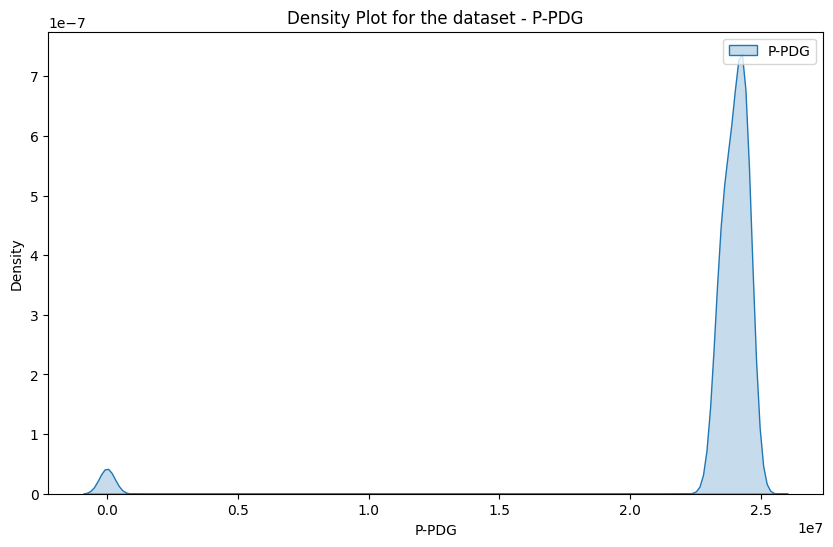

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the attribute for plotting
attribute = 'P-PDG'

# Extract the data for the selected attribute
attribute_data = df[attribute].dropna()

# Plotting the density plot for the selected attribute
plt.figure(figsize=(10, 6))
sns.kdeplot(data=attribute_data, fill=True, label=f"{attribute}")
plt.title(f'Density Plot for the dataset - {attribute}')
plt.xlabel(attribute)
plt.ylabel('Density')
plt.legend()
plt.show()
